In [1]:
import jax
import jax.numpy as jnp
from jax import random, grad, jit, vmap
import haiku as hk
import optax
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import pandas as pd

# Set random seed for reproducibility
def set_seeds(seed=42):
    tf.random.set_seed(seed)
    np.random.seed(seed)

# Load and preprocess MNIST dataset
def load_mnist(split='train'):
    ds = tfds.load('mnist', split=split, as_supervised=True)
    images, labels = [], []
    for image, label in tfds.as_numpy(ds):
        images.append(image)
        labels.append(label)
    return np.array(images, dtype=np.float32) / 255.0, np.array(labels, dtype=np.int32)

# Define CNN architecture
def cnn_fn(x):
    feature_net = hk.Sequential([
        hk.Conv2D(output_channels=16, kernel_shape=3, stride=1, padding="SAME"),
        jax.nn.relu,
        hk.MaxPool(window_shape=2, strides=2, padding="VALID"),
        hk.Conv2D(output_channels=32, kernel_shape=3, stride=1, padding="SAME"),
        jax.nn.relu,
        hk.MaxPool(window_shape=2, strides=2, padding="VALID"),
        hk.Flatten(),
        hk.Linear(5),
        jax.nn.relu
    ])
    features = feature_net(x)
    logits = hk.Linear(10)(features)
    return logits, features

# Count total parameters
def count_parameters(param):
    return sum(x.size for x in jax.tree_util.tree_leaves(param))


In [2]:

# Experimental configuration
expt_name = "mnist_cnn_smaller"
max_steps = 40000
batch_size = 32
logging_period = 500
learning_rate = 1e-4

# Set random seed
set_seeds()

# Load data
train_images, train_labels = load_mnist('train')
test_images, test_labels = load_mnist('test')

# Convert to JAX arrays
train_images, train_labels = jnp.array(train_images), jnp.array(train_labels)
test_images, test_labels = jnp.array(test_images), jnp.array(test_labels)

# Initialize model and optimizer
rng = jax.random.PRNGKey(0)
cnn_model = hk.without_apply_rng(hk.transform(cnn_fn))
dummy_input = jnp.ones([1, 28, 28, 1])
param = cnn_model.init(rng, dummy_input)
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(param)

# Print total parameter count
total_params = count_parameters(param)
print(f"Total parameters: {total_params}")



# Loss function
def loss_fn(param, images, labels):
    logits, _ = cnn_model.apply(param, images)
    one_hot = jax.nn.one_hot(labels, 10)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
    return loss

# Training step
@jit
def train_step(param, opt_state, images, labels):
    loss_val, grads = jax.value_and_grad(loss_fn)(param, images, labels)
    updates, opt_state = optimizer.update(grads, opt_state)
    param = optax.apply_updates(param, updates)
    return param, opt_state, loss_val

# Compute metrics
@jit
def compute_metrics(param, images, labels):
    logits, _ = cnn_model.apply(param, images)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=jax.nn.one_hot(labels, 10)))
    accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
    return loss, accuracy


2024-06-23 14:38:19.345596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-06-23 14:38:20.279973: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Total parameters: 12705


In [3]:

# Training loop
rec = []
t = 0
num_train = len(train_images)
steps_per_epoch = num_train // batch_size

with tqdm(total=max_steps, desc="Training") as pbar:
    while t < max_steps:
        batch_idx = t % steps_per_epoch
        batch_images = train_images[batch_idx*batch_size:(batch_idx+1)*batch_size]
        batch_labels = train_labels[batch_idx*batch_size:(batch_idx+1)*batch_size]
        
        param, opt_state, loss = train_step(param, opt_state, batch_images, batch_labels)
        
        if t % logging_period == 0:
            train_loss, train_accuracy = compute_metrics(param, train_images, train_labels)
            # train_loss, train_accuracy = compute_metrics(param, batch_images, batch_labels)
            test_loss, test_accuracy = compute_metrics(param, test_images, test_labels)
            
            rec.append({
                't': t,
                'train_loss': float(train_loss),
                'train_accuracy': float(train_accuracy),
                'test_loss': float(test_loss),
                'test_accuracy': float(test_accuracy)
            })
            
            print(f"\nStep {t}/{max_steps}:")
            print(f"  Train - Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")
            print(f"  Test  - Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}")
        
        t += 1
        pbar.update(1)

# Final evaluation
final_train_loss, final_train_accuracy = compute_metrics(param, train_images, train_labels)
final_test_loss, final_test_accuracy = compute_metrics(param, test_images, test_labels)

print("\nFinal Results:")
print(f"Train - Loss: {final_train_loss:.4f}, Accuracy: {final_train_accuracy:.4f}")
print(f"Test  - Loss: {final_test_loss:.4f}, Accuracy: {final_test_accuracy:.4f}")


Training:   0%|          | 0/40000 [00:00<?, ?it/s]


Step 0/40000:
  Train - Loss: 2.2998, Accuracy: 0.0982
  Test  - Loss: 2.3011, Accuracy: 0.0956

Step 500/40000:
  Train - Loss: 1.7236, Accuracy: 0.4126
  Test  - Loss: 1.7335, Accuracy: 0.4108

Step 1000/40000:
  Train - Loss: 1.4917, Accuracy: 0.5082
  Test  - Loss: 1.4975, Accuracy: 0.5084

Step 1500/40000:
  Train - Loss: 1.3488, Accuracy: 0.5420
  Test  - Loss: 1.3494, Accuracy: 0.5439

Step 2000/40000:
  Train - Loss: 1.2298, Accuracy: 0.5823
  Test  - Loss: 1.2296, Accuracy: 0.5866

Step 2500/40000:
  Train - Loss: 1.1387, Accuracy: 0.6177
  Test  - Loss: 1.1361, Accuracy: 0.6218

Step 3000/40000:
  Train - Loss: 1.0773, Accuracy: 0.6212
  Test  - Loss: 1.0749, Accuracy: 0.6251

Step 3500/40000:
  Train - Loss: 1.0200, Accuracy: 0.6425
  Test  - Loss: 1.0184, Accuracy: 0.6437

Step 4000/40000:
  Train - Loss: 0.9783, Accuracy: 0.6511
  Test  - Loss: 0.9760, Accuracy: 0.6539

Step 4500/40000:
  Train - Loss: 0.9426, Accuracy: 0.6674
  Test  - Loss: 0.9408, Accuracy: 0.6672

Ste

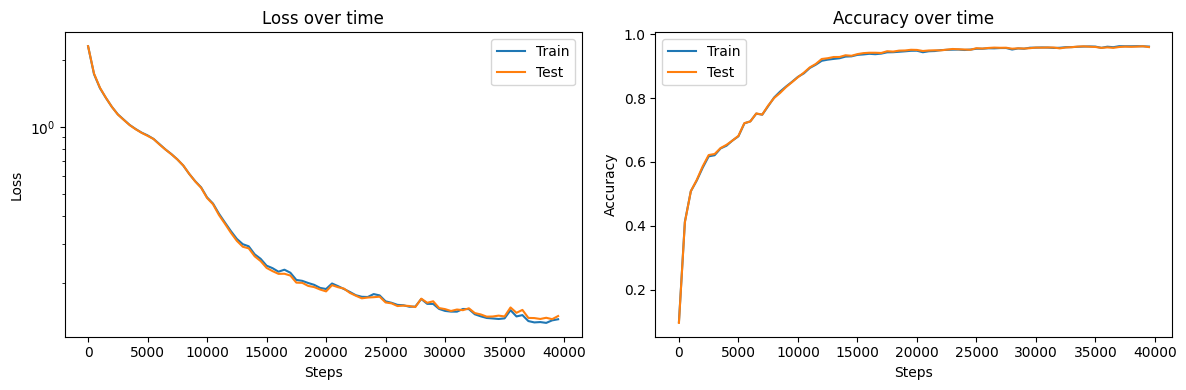

In [4]:
# Visualization
df = pd.DataFrame(rec)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ax = axes[0]
ax.plot(df['t'], df['train_loss'], label='Train')
ax.plot(df['t'], df['test_loss'], label='Test')
ax.set_xlabel('Steps')
ax.set_ylabel('Loss')
ax.legend()
ax.set_title('Loss over time')
ax.set_yscale('log')

ax = axes[1]
ax.plot(df['t'], df['train_accuracy'], label='Train')
ax.plot(df['t'], df['test_accuracy'], label='Test')
ax.set_xlabel('Steps')
ax.set_ylabel('Accuracy')
ax.legend()
ax.set_title('Accuracy over time')

plt.tight_layout()
plt.show()

In [5]:
from sgld_utils import SGLDConfig
from sgld_utils import create_minibatches, run_sgld
from dln import create_dln_model
import jax.tree_util as jtree


def param_dist(param1, param2, ord=2):
    return np.sum(jtree.tree_leaves(jtree.tree_map(lambda x, y: np.sum((x - y)**ord), param1, param2)))**(1/ord)


expt_name = "mnist_features_stagewise_learning"
do_llc_estimation = False

input_dim = 3
output_dim = 10
hidden_layer_widths = [12, 12, 12]

sgld_config = {
    'epsilon': 5e-9,
    'gamma': 1.0,
    'num_steps': 200,
    "num_chains": 1, # TODO: not implemented chains
    "batch_size": 256
}
loss_trace_minibatch = True # if True loss_trace uses minibatch, else use full dataset. 
initialisation_exponent = 1.5
scale_init_param = .3

num_training_data = len(train_images)
itemp = 1 / np.log(num_training_data)
training_config = {
    "optim": "sgd", 
    "learning_rate": 0.0001, 
    "momentum": None, 
    "batch_size": 32, 
    "num_steps": 200001
}
seed = 42
logging_period = 1000

# seeding
np.random.seed(seed)
rngkey = jax.random.PRNGKey(seed)

sgld_config = SGLDConfig(**sgld_config)


param_feature_network = param
feature_map = lambda x: cnn_model.apply(param_feature_network, x)[1]
feat_x_dummy = feature_map(jnp.ones((1, 28, 28, 1)))
feature_dim = feat_x_dummy.shape[-1]

print(f"Input dim: {input_dim}, feature dim {feature_dim}, output dim: {output_dim}")

####################
# Initialisations
####################
num_hidden_layers = len(hidden_layer_widths)
layer_widths = hidden_layer_widths + [output_dim]
num_layers = len(layer_widths)
print(f"Layer widths: {layer_widths}")

# DLN model
initialisation_sigma = np.sqrt(np.mean(layer_widths) ** (-initialisation_exponent))
print(f"Initialisation sigma: {initialisation_sigma}")
model_dln = create_dln_model(layer_widths, sigma=initialisation_sigma)
rngkey, subkey = jax.random.split(rngkey)
init_param_dln = model_dln.init(rngkey, feat_x_dummy)
print(f"Model parameter shapes:")
print(jtree.tree_map(lambda x: x.shape, init_param_dln))






# Model prediction function
def predict(param_dln, x):
    phi_x = feature_map(x)
    print(f"phi_x shape: {phi_x.shape}")
    return model_dln.apply(param_dln, phi_x)

# Loss function
@jit
def loss_fn(params, x, y):
    y_pred = predict(params, x)
    return jnp.mean(optax.softmax_cross_entropy(logits=y_pred, labels=y))

# Training function
@jit
def update(params, opt_state, batch):
    inputs, targets = batch
    grads = grad(loss_fn)(params, inputs, targets)
    updates, opt_state = optimizer.update(grads, opt_state)
    params = optax.apply_updates(params, updates)
    return params, opt_state



itemp = 1 / np.log(num_training_data)
sigma = 0.3
input_sigma = 1.0
rngkey, subkey = random.split(rngkey)
x_train = train_images[:num_training_data]
y_train = jax.nn.one_hot(train_labels[:num_training_data], 10)
x_test = test_images
y_test = jax.nn.one_hot(test_labels, 10)


if scale_init_param: 
    init_param_dln = jtree.tree_map(lambda x: x * scale_init_param, init_param_dln)

# Set up optimizer
learning_rate = training_config["learning_rate"]
# optimizer = optax.sgd(learning_rate)
optimizer = optax.adam(learning_rate)
opt_state = optimizer.init(init_param_dln)
param_dln = init_param_dln

# Training loop
t = 0
records = []
while t < training_config["num_steps"]:
    for batch in create_minibatches(x_train, y_train, batch_size=training_config["batch_size"]):
        param_dln, opt_state = update(param_dln, opt_state, batch)
        if t % logging_period == 0:
            current_loss = loss_fn(param_dln, x_train, y_train)
            test_loss = loss_fn(param_dln, x_test, y_test)
            total_matrix = jnp.linalg.multi_dot(
                [param_dln[f'deep_linear_network/linear{loc}']['w'] 
                 for loc in [''] + [f'_{i}' for i in range(1, num_layers)]]
            )
            rec = {
                "t": t + 1,
                "train_loss": float(current_loss),
                "test_loss": float(test_loss),
                "param": param, 
                "total_matrix": total_matrix, 
            }
            if do_llc_estimation:
                y = predict(param, x_train)
                rngkey, subkey = jax.random.split(rngkey)
                loss_trace, distances, acceptance_probs = run_sgld(
                    subkey, 
                    loss_fn, 
                    sgld_config, 
                    param, 
                    x_train, 
                    y,
                    itemp=itemp, 
                    trace_batch_loss=True, 
                    compute_distance=False, 
                    verbose=False, 
                    compute_mala_acceptance=False
                )
                
                init_loss = loss_fn(param, x_train, y)
                burn_in_prop = 0.9
                burn_in = int(burn_in_prop * len(loss_trace))
                lambdahat = float(np.mean(loss_trace[burn_in:]) - init_loss) * num_training_data * itemp

                
                rec.update(
                    {
                        "lambdahat": float(lambdahat),
                        # "loss_trace": loss_trace, 
                        # "init_loss": float(init_loss),
                    }
                )
            print(
                f"t: {t + 1:7d}, "
                f"Loss: {current_loss:5.5f}, "
                + (f"LLC: {lambdahat:3.3f}" if do_llc_estimation else ""))
            records.append(rec)

        t += 1
        if t >= training_config["num_steps"]:
            break


Input dim: 3, feature dim 5, output dim: 10
Layer widths: [12, 12, 12, 10]
Initialisation sigma: 0.16013144391807144
Model parameter shapes:
{'deep_linear_network/linear': {'w': (5, 12)}, 'deep_linear_network/linear_1': {'w': (12, 12)}, 'deep_linear_network/linear_2': {'w': (12, 12)}, 'deep_linear_network/linear_3': {'w': (12, 10)}}
phi_x shape: (32, 5)


phi_x shape: (60000, 5)
phi_x shape: (10000, 5)
t:       1, Loss: 2.30238, 
t:    1001, Loss: 1.63297, 
t:    2001, Loss: 0.69816, 
t:    3001, Loss: 0.53970, 
t:    4001, Loss: 0.49669, 
t:    5001, Loss: 0.47303, 
t:    6001, Loss: 0.45507, 
t:    7001, Loss: 0.44371, 
t:    8001, Loss: 0.43282, 
t:    9001, Loss: 0.42517, 
t:   10001, Loss: 0.41949, 
t:   11001, Loss: 0.41424, 
t:   12001, Loss: 0.40934, 
t:   13001, Loss: 0.40430, 
t:   14001, Loss: 0.39921, 
t:   15001, Loss: 0.38883, 
t:   16001, Loss: 0.37258, 
t:   17001, Loss: 0.33982, 
t:   18001, Loss: 0.28297, 
t:   19001, Loss: 0.22208, 
t:   20001, Loss: 0.18266, 
t:   21001, Loss: 0.16250, 
t:   22001, Loss: 0.15233, 
t:   23001, Loss: 0.14708, 
t:   24001, Loss: 0.14342, 
t:   25001, Loss: 0.14174, 
t:   26001, Loss: 0.13982, 
t:   27001, Loss: 0.13939, 
t:   28001, Loss: 0.13894, 
t:   29001, Loss: 0.13860, 
t:   30001, Loss: 0.13829, 
t:   31001, Loss: 0.13855, 
t:   32001, Loss: 0.13822, 
t:   33001, Loss: 0.13782, 


[1605.5422     65.753395   37.164524   46.16388     0.      ]
[1.6055422e+03 6.5753395e+01 3.7164524e+01 4.6163879e+01 3.7164524e-01]


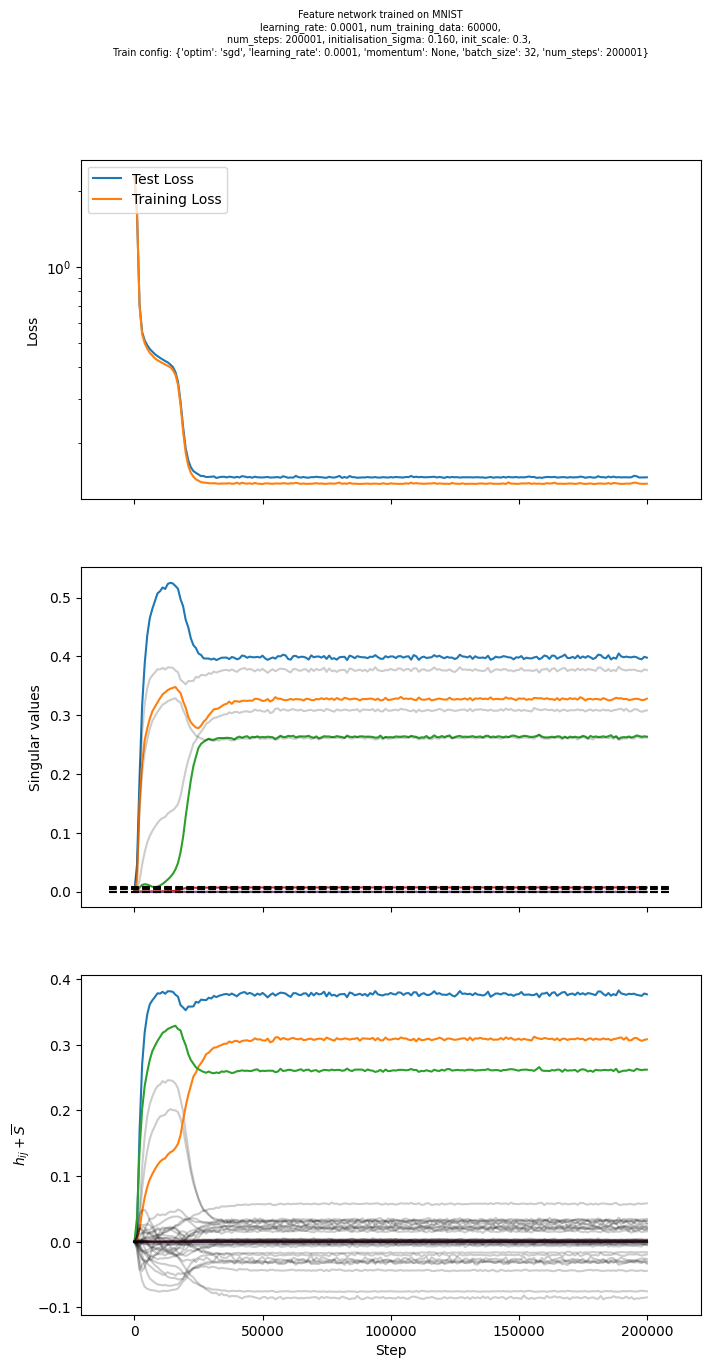

In [6]:
df_data = pd.DataFrame(records)
df = df_data.copy(deep=True)
# df = df[df["t"] > 10].copy(deep=True)

df["singular_values"] = df["total_matrix"].apply(lambda x: np.linalg.svd(x, compute_uv=False))
phi_train = feature_map(x_train)
feature_correlation_matrix = phi_train.T @ phi_train / num_training_data
eigvals, eigvecs = np.linalg.eig(feature_correlation_matrix)
print(eigvals)
eigvals[eigvals == 0.0] += np.min(eigvals[eigvals > 0.0]) * 0.01
print(eigvals)
feature_output_cross_correlation = y_train.T @ phi_train / num_training_data

ChangeOfBasis = eigvecs @ np.diag(eigvals ** (-3/2))
modified_feature_output_cross_correlation = feature_output_cross_correlation @ ChangeOfBasis 
Ubar, Sbar, Vbar = np.linalg.svd(modified_feature_output_cross_correlation)



df["corrected_total_matrix"] = df["total_matrix"].apply(
    lambda total_mat: Ubar.T @ np.array(total_mat).T @ feature_correlation_matrix @ ChangeOfBasis @ Vbar.T
)
df["corrected_singular_values"] = df["corrected_total_matrix"].apply(
    lambda x: np.linalg.svd(x, compute_uv=False)
)

df["corrected_total_matrix_diag"] = df["corrected_total_matrix"].apply(
    lambda x: [x[i, i] for i in range(min(x.shape[0], x.shape[1]))]
)


df["potential_matrix"] = df["corrected_total_matrix"].apply(
    lambda x: x  # - np.fill_diagonal(np.zeros_like(x), Sbar)
)



fig, axes = plt.subplots(3, 1, figsize=(8, 15), sharex=True)
ax = axes[0]
if "test_loss" in df.columns:
    ax.plot(df["t"], df["test_loss"], label="Test Loss")

ax.plot(df["t"], df["train_loss"], label="Training Loss")
ax.set_ylabel("Loss")
ax.legend(loc="upper left")
ax.set_yscale("log")


ax = axes[1]
for i in range(min(feature_dim, output_dim)):
    ax.plot(
        df["t"],
        df["corrected_singular_values"].apply(lambda x: x[i]), 
    )

    ax.plot(
        df["t"],
        df["corrected_total_matrix_diag"].apply(lambda x: x[i]), 
        color="k",
        alpha=0.2,
    )

xmin, xmax = ax.get_xlim()
ax.hlines(Sbar, xmin, xmax, color="k", linestyle="--", label="true singular values")
ax.set_ylabel("Singular values")
# ax.legend()

# for i in range(feature_dim):
#     for j in range(output_dim):
#         ax.plot(df["t"], df["total_matrix"].apply(lambda x: np.array(x)[i, j]), label=f"({i}, {j})")
# ax.set_ylabel("$[W_N \dots W_2 W_1]_{ij}$")


ax = axes[2]
for i in range(output_dim):
    for j in range(feature_dim):
        # if i != j: continue
        if i != j:
            ax.plot(
                df["t"],
                df["corrected_total_matrix"].apply(lambda x: x[i, j]), 
                color="k",
                alpha=0.2,
            )
        else:
            ax.plot(
                df["t"],
                df["corrected_total_matrix"].apply(lambda x: x[i, j]), 
                # color="k",
                # alpha=0.5,
            )
ax.set_ylabel("$h_{ij} + \overline{S}$")


for i, ax in enumerate(axes):
    if i == len(axes) - 1:
        ax.set_xlabel("Step")
    # ax.set_yscale("log")
    # ax.set_xscale('log')
    pass

suptitle = (
    f"Feature network trained on MNIST\n"
    f"learning_rate: {learning_rate}, "
    f"num_training_data: {num_training_data},\n"
    f"num_steps: {training_config['num_steps']}, "
    f"initialisation_sigma: {initialisation_sigma:.3f}, "
    f"init_scale: {scale_init_param}, "
    f"\nTrain config: {training_config}"
)
if do_llc_estimation:
    suptitle += '\n' + ', '.join([f"{k}: {v}" for k, v in sgld_config])
fig.suptitle(suptitle, fontsize="x-small");

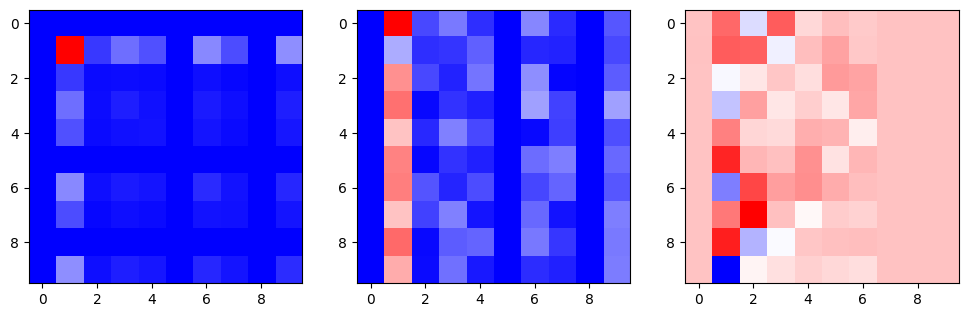

In [12]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
cmap = "bwr"
ax = axes[0]
ax.imshow(feature_correlation_matrix, cmap=cmap)

ax = axes[1]
ax.imshow(feature_output_cross_correlation, cmap=cmap)

ax = axes[2]
ax.imshow(modified_feature_output_cross_correlation, cmap=cmap)

[1.2934241e+03 1.9803066e+01 2.8674871e+01 9.6308090e+01 5.5118755e+01
 8.1261818e+01 6.8545517e+01 1.9803067e-01 1.9803067e-01 1.9803067e-01]


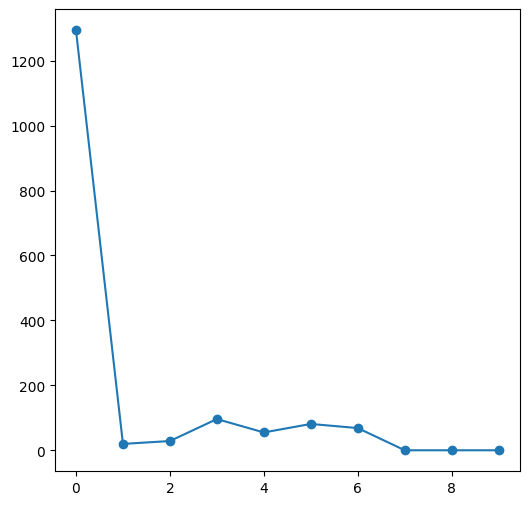

In [56]:
print(eigvals)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.plot(eigvals, 'o-')
# ax.set_yscale("log")

1

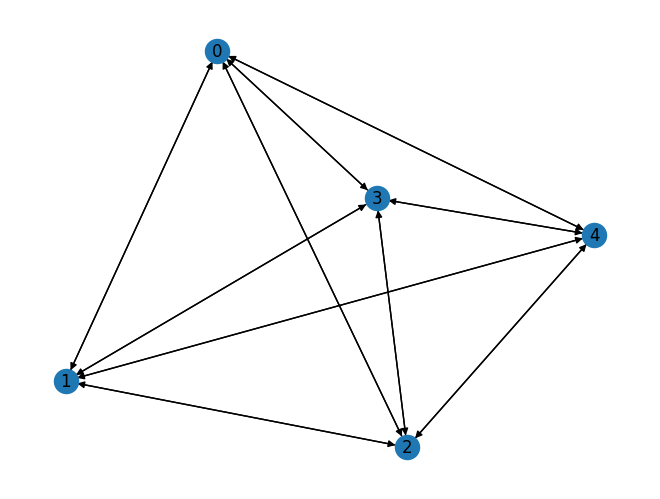

In [13]:
import numpy as np
cost = {}
def top_down(graph, source, target):
    if source == target:
        return 0
    
    if (source, target) in graph:
        return graph[(source, target)]

    if (source, target) in cost:
        return cost[(source, target)]
        
    result = min(
        top_down(graph, source, node) + top_down(graph, node, target)
        for node in graph
    )
    cost[(source, target)] = result
    return result



g = np.random.randint(0, 10, (5, 5))
np.fill_diagonal(g, 0)
g_dict = {}
for i in range(5):
    for j in range(5):
        if i != j:
            g_dict[(i, j)] = g[i, j]

import networkx as nx
G = nx.DiGraph()
G.add_nodes_from(range(5))
for i in range(5):
    for j in range(5):
        if i != j:
            G.add_edge(i, j, weight=g[i, j])

nx.draw(G, with_labels=True)

top_down(g_dict, 0, 2)


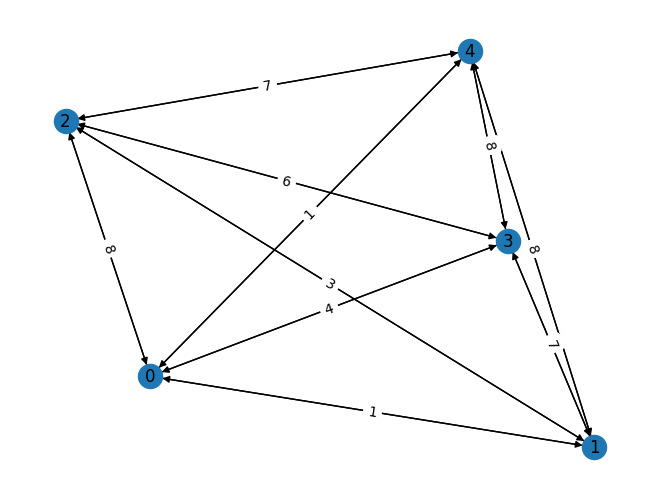

0 1 4
0 2 5
0 3 8
0 4 4
1 0 1
1 2 3
1 3 9
1 4 3
2 0 8
2 1 3
2 3 2
2 4 8
3 0 4
3 1 7
3 2 6
3 4 6
4 0 1
4 1 8
4 2 7
4 3 8


In [20]:
# use nx to plot graphs with edge weights
import networkx as nx
import matplotlib.pyplot as plt



g = np.random.randint(1, 10, (5, 5))
np.fill_diagonal(g, 0)
g_dict = {}
for i in range(5):
    for j in range(5):
        if i != j:
            g_dict[(i, j)] = g[i, j]

G = nx.DiGraph()
G.add_nodes_from(range(5))
for i in range(5):
    for j in range(5):
        if i != j:
            G.add_edge(i, j, weight=g[i, j])

pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()

for i in range(5):
    for j in range(5):
        if i != j:
            print(i, j, top_down(g_dict, i, j))


In [21]:
g

array([[0, 4, 5, 8, 4],
       [1, 0, 3, 9, 3],
       [8, 3, 0, 2, 8],
       [4, 7, 6, 0, 6],
       [1, 8, 7, 8, 0]])